In [20]:
# Dependencies
import pandas as pd
import requests
from census import Census
import json
import gmaps
import matplotlib.pyplot as plt 
import matplotlib.ticker as mtick
import numpy as np

# Census & gmaps API Keys
from config import (api_key,gkey)

# Configure gmaps with API key
gmaps.configure(api_key=gkey)

# Build the endpoint URL
base_url = ('https://maps.googleapis.com/maps/api/geocode/json?')

# declare csv output path
csv_path = '../Resources/census_city.csv'

# declare csv output path
img_path = '../Resources/Top_10_Cities_Population.png'

c = Census(api_key, year=2018)

In [21]:
# Get Census Population Data for cities
census_data = c.acs5.get(("NAME", "B01003_001E"), {'for': 'place:*'})

# Convert to DataFrame
census_df = pd.DataFrame(census_data)

# Column Reordering
census_df = census_df.rename(columns={"B01003_001E": "Population",
                                      "NAME": "City", "place": "Place"})

print(f'There are {len(census_df)} cities in the census_df dataset.')

There are 29573 cities in the census_df dataset.


In [22]:
# create df of cities where the population is greater than 250000
big_city_df = census_df.loc[census_df['Population'] > 250000]
                            
print(f'There are {len(big_city_df)} cities in the big city dataset.')
big_city_df.head()

There are 84 cities in the big city dataset.


,City,Population,state,Place
243,"Kansas City city, Missouri",481417.0,29,38000
1311,"Omaha city, Nebraska",465112.0,31,37000
1319,"Lincoln city, Nebraska",280849.0,31,28000
1524,"St. Louis city, Missouri",311273.0,29,65000
2265,"Jersey City city, New Jersey",261746.0,34,36000


In [23]:
# Create a df with City and State values separated
City_State = big_city_df["City"].str.split(" city,", n = 1, expand = True) 

# merge city_state with the big city df
city_merge_df = pd.merge(big_city_df, City_State, right_index=True, left_index=True)

# rename the city and state columns
city_merge_df.rename(columns = {0 :'Clean_City', 1 : 'Clean_State'}, inplace = True)

# create a City_State column
city_merge_df['City_State'] = city_merge_df['Clean_City'].map(str) +','+ city_merge_df['Clean_State'].map(str)

# create columns for lat and lng
city_merge_df["Lat"] = np.NaN
city_merge_df["Lng"] = np.NaN

# loop through city merge df and set lat and lng for each record
for index, row in city_merge_df.iterrows():
    
    try:
        url = base_url + 'address=' + row[0] + '&key=' + gkey      
        response = requests.get(url).json() 
        
        lat_response = response["results"][0]["geometry"]["location"]["lat"]
        lng_response = response["results"][0]["geometry"]["location"]["lng"]
    
        city_merge_df.loc[index, "Lat"] = lat_response
        city_merge_df.loc[index, "Lng"] = lng_response
        
        print(f'{row[0]} is completed  with lat: {lat_response} lng: {lng_response}.')
    except:
        print(f'{row[0]} was not processed...')

# create final city df
final_city_df = city_merge_df[['City_State','Clean_City','Population','Lat','Lng']]

# drop NaN values
final_city_df.dropna()

Kansas City city, Missouri is completed  with lat: 39.0997265 lng: -94.5785667.
Omaha city, Nebraska is completed  with lat: 41.2565369 lng: -95.9345034.
Lincoln city, Nebraska is completed  with lat: 40.813616 lng: -96.7025955.
St. Louis city, Missouri is completed  with lat: 38.6270025 lng: -90.19940419999999.
Jersey City city, New Jersey is completed  with lat: 40.7177545 lng: -74.0431435.
Henderson city, Nevada is completed  with lat: 36.0395247 lng: -114.9817213.
Las Vegas city, Nevada is completed  with lat: 36.1699412 lng: -115.1398296.
Newark city, New Jersey is completed  with lat: 40.735657 lng: -74.1723667.
Albuquerque city, New Mexico is completed  with lat: 35.0843859 lng: -106.650422.
Buffalo city, New York is completed  with lat: 42.88644679999999 lng: -78.8783689.
Charlotte city, North Carolina is completed  with lat: 35.2270869 lng: -80.8431267.
New York city, New York is completed  with lat: 40.7127753 lng: -74.0059728.
Raleigh city, North Carolina is completed  with 

,City_State,Clean_City,Population,Lat,Lng
243,"Kansas City, Missouri",Kansas City,481417.0,39.099727,-94.578567
1311,"Omaha, Nebraska",Omaha,465112.0,41.256537,-95.934503
1319,"Lincoln, Nebraska",Lincoln,280849.0,40.813616,-96.702596
1524,"St. Louis, Missouri",St. Louis,311273.0,38.627003,-90.199404
2265,"Jersey City, New Jersey",Jersey City,261746.0,40.717754,-74.043143
...,...,...,...,...,...
27490,"New Orleans, Louisiana",New Orleans,389648.0,29.951066,-90.071532
28347,"St. Paul, Minnesota",St. Paul,302760.0,44.953703,-93.089958
28414,"Minneapolis, Minnesota",Minneapolis,416021.0,44.977753,-93.265011
28450,"Boston, Massachusetts",Boston,679413.0,42.360082,-71.058880


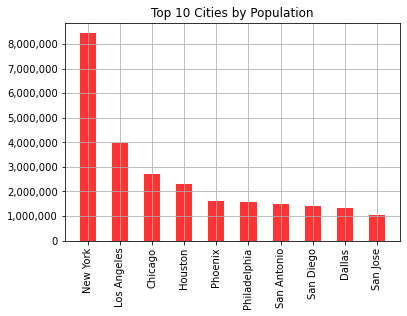

In [24]:
# Create bar chart showing the top 10 cities by peopulation

# create a df with population sorty by greatest
pareto_df = final_city_df.sort_values(by =['Population'], ascending = False)

# select the first 10 records
pareto_df = pareto_df.head(10)

# create lists for city an population
city = pareto_df['Clean_City'].tolist()
population = pareto_df['Population'].tolist()

# declare fig and ax
fig, ax = plt.subplots()

# get rid of scientific notation
ax.ticklabel_format(style='plain')

# format y ticker
fmt = '{x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick) 

# set x axis 
x_axis = np.arange(len(city))
x_labels = city

# set the ticks etc
tick_locations = [x for x in x_axis]
plt.xticks(tick_locations, x_labels, rotation=90)

# set the title
plt.title("Top 10 Cities by Population")

# plot the bar chart
ax.bar(city, population, color='red', alpha=0.8, align="center", width=.5)

plt.grid()
# save the bar chart to the Resources folder
plt.savefig(img_path,bbox_inches='tight')
plt.show()

In [25]:
# write csv file of the city data to the Resources folder
final_city_df.to_csv(csv_path)

In [26]:
figure_layout = {
    'width': '900px',
    'height': '600px',
    'border': '1px solid black',
    'padding': '1px',
    'margin': '0 auto 0 auto'
}

# Create a poverty Heatmap layer
locations = final_city_df[["Lat", "Lng"]].astype(float)

population = final_city_df["Population"].astype(float)

# get the max population
max_pop = population.max()

fig = gmaps.figure(layout=figure_layout)



heat_layer = gmaps.heatmap_layer(locations, weights=population,
                                 dissipating=False, max_intensity=max_pop,
                                 point_radius = 3)

fig.add_layer(heat_layer)

fig

Figure(layout=FigureLayout(border='1px solid black', height='600px', margin='0 auto 0 auto', padding='1px', wi…